# Implementing K-Means Clustering from scratch


In the implementation, cluster centers are initialized with random data points. The label of each data point is updated based on the cosine similarity between the point and cluster centers. Cluster centers are calculated by grouping the data points based on the label and then performing vectorized averaged operation. Finally Sum of Squared Errors (SSE) is calculated using euclidean distance between final centers and documents in the cluster.


Variation Ratio:  [0.21336063 0.13999719]


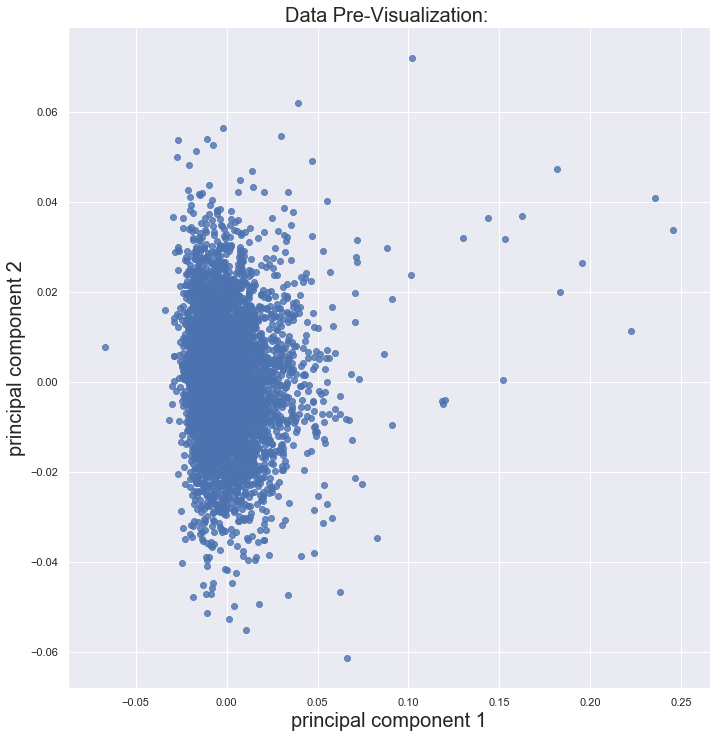

In [1]:
# K- Means
import numpy as np
import pandas as pd
from scipy import spatial
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

class K_Means:
    
    def __init__(self, filepath, ndims):
        self.__column_names = list(range(ndims))
        # DataFrame containing features with index name 'Index'
        self.__df = pd.read_csv('docs_vector_final.csv', names = ['Index'] + self.__column_names, index_col = 0, header=None)
       
        # No of dims in input
        self.__ndim = ndims
        
        # Find Principal Components for visualization
        self.__pca()
        
        
        # Random Samples for visualization
        np.random.seed(seed=100)
        self.__random_samples = np.random.choice(self.__df.shape[0], 5000, replace=False)
        
        # Visualization Parameter Set
        sns.set(rc={'figure.figsize':(10,10)})
        
        
        
    def __pca(self):
        # PCA Decomposition for Visualization
        pca = PCA(n_components=2)
        principalComponents = pca.fit_transform(self.__df)
        print('Variation Ratio: ', pca.explained_variance_ratio_)
        self.__principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])
    
    
    def pre_visualize(self):
        df_sample = self.__principalDf.iloc[self.__random_samples,]
        lm = sns.lmplot(data=df_sample, x='pc1', y='pc2', 
                   fit_reg=False, legend=False, legend_out=True,height=10)
        plt.xlabel('principal component 1', fontsize = 20)
        plt.ylabel('principal component 2', fontsize = 20)
        plt.title('Data Pre-Visualization: ', fontsize = 20)
        #plt.xlim([-0.05, 0.1])
        #plt.ylim([-0.05, 0.1])
        
    def __init_centers(self):
        #np.random.seed(0)
        # Initialize random data points as initial centers
        self.__centers = self.__df.reset_index().drop(['Index'], axis = 1).sample(n = self.__K)
        self.__centers.columns = self.__column_names
        self.__centers.index = pd.RangeIndex(len(self.__centers.index))
        
    def get_centers(self):
        return self.__centers
    
    def get_labels(self):
        return self.__df2['label']
    
    def __update_label(self):
        # Update Labels based on cosine similarity
        ary = spatial.distance.cdist(self.__df.iloc[:,0:], self.__centers.iloc[:,0:], metric='cosine')
        ary = pd.DataFrame(ary)

        label = ary.idxmin(axis = 1)
        self.__label = label
        self.__df2 = self.__df.copy().reset_index()
        self.__df2['label'] = label
        self.__df2 = self.__df2.set_index('Index')
        
    def __update_center(self):
        # Update Centers based on label group
        df_group_by_label = self.__df2.groupby('label').mean()
        df_group_by_label.columns = self.__column_names
        self.__old_centers = self.__centers.copy(deep = True)
        self.__centers.update(df_group_by_label)
        
    def __calc_SSE(self):
        # Calculate Sum of Squared Errors: SSE
        self.__SSE = 0
        self.__sseList = []
        clusters_df = self.__df2.groupby('label')
        for label_, df_ in clusters_df:
            df_ = df_.drop(['label'], axis = 1)
            center_ = self.__centers.iloc[label_,0:].to_frame().T
            ary_ = spatial.distance.cdist(df_.iloc[:,0:], center_, metric='euclidean')**2
            sse = ary_.sum()
            self.__SSE += sse
            self.__sseList.append(sse)

    def run(self, K):
        # No of Clusters to be made
        self.__K = K
        print('K-Means Clustering Run for K = ', self.__K)
        self.__init_centers()
        
        for i in range(100):
            # Update Label
            self.__update_label()

            # Center Update
            self.__update_center()

            error = self.__old_centers.subtract(self.__centers)**2
            #print('Error in Iteration', i, ': ', error.values.sum())
            self.__calc_SSE()
            #print('SSE in Iteration', i, ': ', self.get_SSE())
            if(error.values.sum() < 10**(-6)):
                print("K-Means Iteration = ", i+1)
                break
                
        self.__calc_SSE()
        
    def get_SSE(self):
        return self.__SSE
    
    def get_sseList(self):
        return self.__sseList
        
    def label_histogram(self):
        # Visualize Distribution of document count
        label_series = self.__df2['label'].value_counts().sort_index()
        ax = sns.barplot(label_series.index, label_series.values)
        ax.set_xlabel('Cluster lebel', fontsize = 20)
        ax.set_ylabel('# Documents', fontsize = 20)
        ax.set_title('K-Means Clustering with K = ' + str(self.__K), fontsize = 20)
        
    def post_visualize(self):
        # Visualize Distribution of data
        self.__principalDf['label'] = self.__label#self.get_labels()
        df2_sample = self.__principalDf.iloc[self.__random_samples,]
        lm = sns.lmplot(data=df2_sample, x='pc1', y='pc2', hue='label', 
                  fit_reg=False, legend=False, legend_out=True,height=10)
        #sns.scatterplot(data=df2_sample, x='principal component 1', y='principal component 2', hue='label')
        plt.xlabel('principal component 1', fontsize = 20)
        plt.ylabel('principal component 2', fontsize = 20)
        plt.title('Data Post-Visualization: ', fontsize = 20)
        plt.xlim([-0.05, 0.2])
        plt.ylim([-0.05, 0.06])
        
        
    def annotated_visualize(self):
        # Visualize data with its unique identifier 'awardNo'
        samples = np.random.choice(self.__df.shape[0], 50, replace=False)
        df3_sample = self.__principalDf.iloc[samples,]
#         lm = sns.lmplot(data=df3_sample, x='principal component 1', y='principal component 2', hue='label', 
#                    fit_reg=False, legend=False, legend_out=True)
        fig = plt.figure(figsize = (15,15))
        ax = fig.add_subplot(1,1,1)
        plt.xlabel('principal component 1', fontsize = 20)
        plt.ylabel('principal component 2', fontsize = 20)
        plt.title('Data Post-Visualization: ', fontsize = 20)
        xlim_value = [-0.025, 0.025]
        ylim_value = [-0.025, 0.025]
        plt.xlim(xlim_value)
        plt.ylim(ylim_value)
        ax.scatter(df3_sample['pc1']
               , df3_sample['pc2']
               , c = [self.__label[i] for i in df3_sample.index.values]
               , s = 50)
        #ax.legend(kmeans.labels_)
        ax.grid()

        for line in range(0,df3_sample.shape[0]):
            x_val = df3_sample['pc1'].values[line]
            y_val = df3_sample['pc2'].values[line]
            #annt_text = str(df3_sample.index.values[line])
            annt_text = str(self.__df2.index.values[line])
            if(x_val < xlim_value[0] or x_val > xlim_value[1]):
                continue
            if(y_val < ylim_value[0] or y_val > ylim_value[1]):
                continue
            #lm.ax.fig.text(x_val, y_val, annt_text)
            #lm.ax.text(annt_text, xy = (x_val, y_val))
            ax.annotate(annt_text, xy = (x_val, y_val))
        
    
# K_Means(Input DataFrame, Input Dimension)
obj = K_Means('docs_vector_final.csv', 300)
obj.pre_visualize()

## The distribution of documents in different clusters.

K-Means Clustering Run for K =  2
K-Means Iteration =  8
SSE =  61.20351918512949


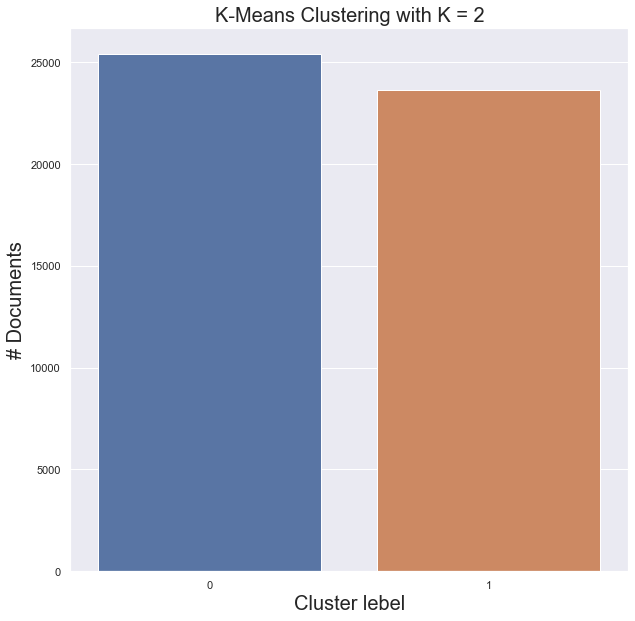

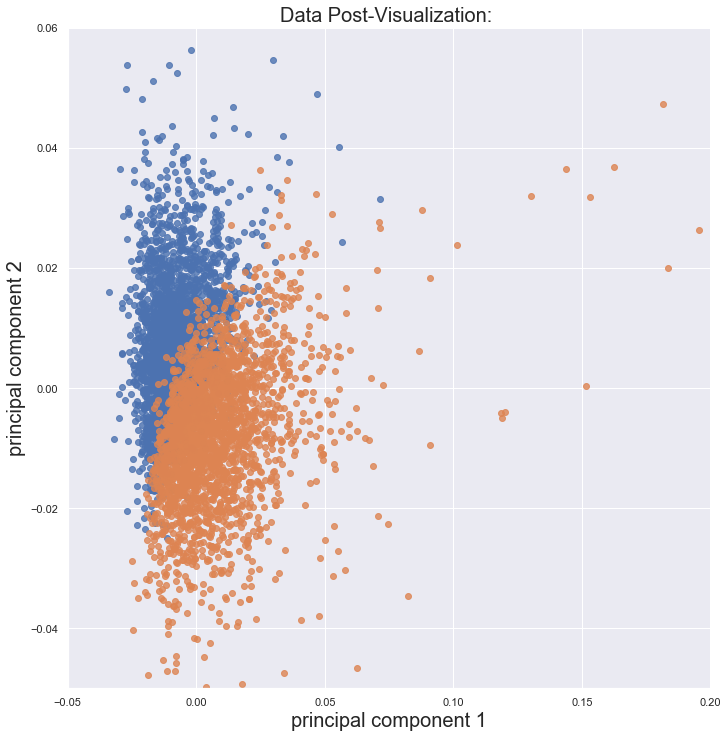

In [2]:
K = 2
obj.run(K)
obj.label_histogram()
obj.post_visualize()
#obj.get_labels().head()
sse = obj.get_SSE()
print('SSE = ', sse)

K-Means Clustering Run for K =  3
K-Means Iteration =  11
SSE =  55.14411857476252


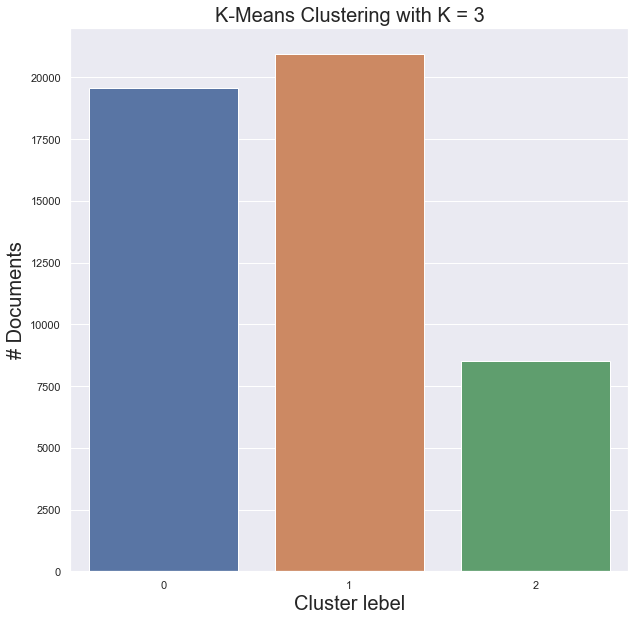

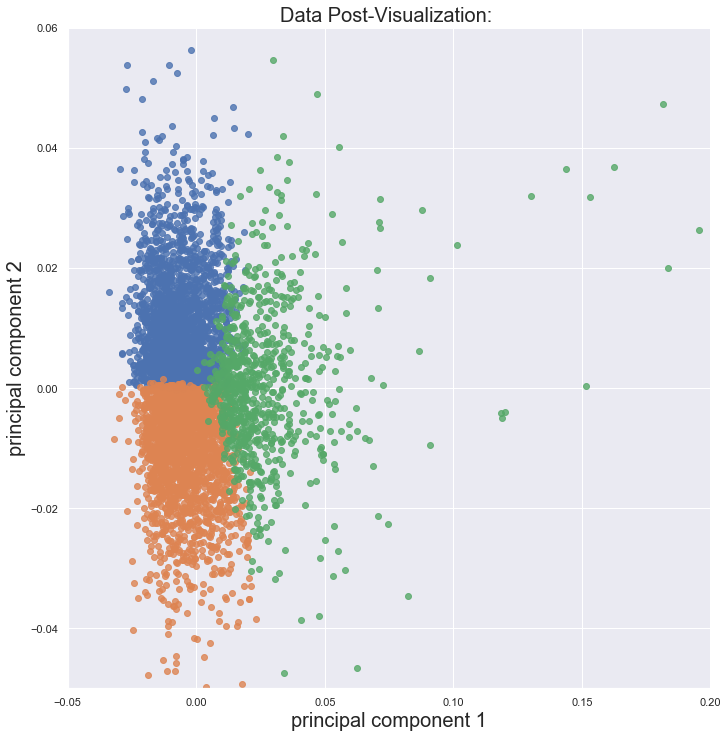

In [3]:
K = 3
obj.run(K)
obj.label_histogram()
obj.post_visualize()
#obj.get_labels().head()
sse = obj.get_SSE()
print('SSE = ', sse)

### The distribution of data with annotated unique document identifier 'award number'

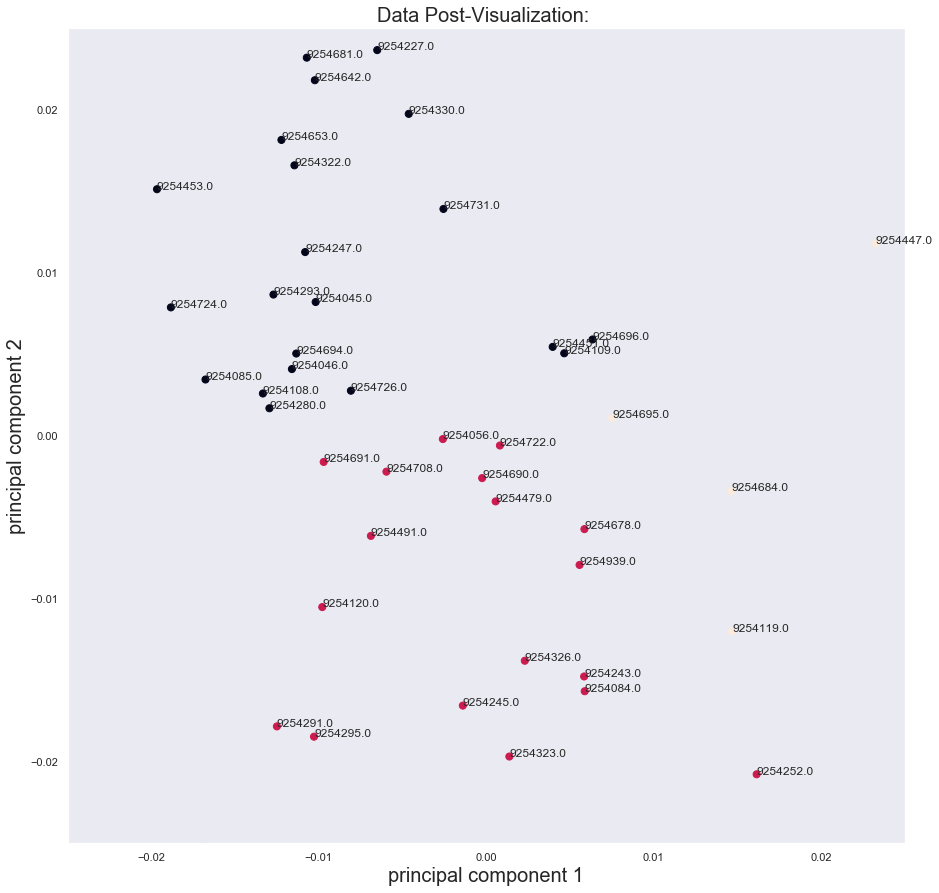

In [4]:
obj.annotated_visualize()

### The Elbow Method: determine the optimal number of clusters using K-Means SSE Profile

In [5]:
SSE_list = []
for K in range(1,7):
    obj.run(K)
    SSE_list.append(obj.get_sseList())
    
    

K-Means Clustering Run for K =  1
K-Means Iteration =  2
K-Means Clustering Run for K =  2
K-Means Iteration =  6
K-Means Clustering Run for K =  3
K-Means Iteration =  15
K-Means Clustering Run for K =  4
K-Means Iteration =  10
K-Means Clustering Run for K =  5
K-Means Iteration =  8
K-Means Clustering Run for K =  6
K-Means Iteration =  15


In [6]:
df_sse = pd.DataFrame(SSE_list)

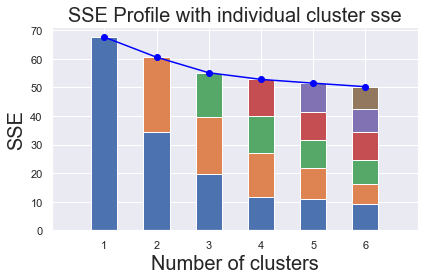

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
ax = df_sse.plot(kind='bar', stacked = True)
df_sse.T.sum().plot(kind='line', color='blue', style = '-o')
ax.get_legend().remove() 
plt.xlabel('Number of clusters', fontsize = 20)
plt.ylabel('SSE', fontsize = 20)
ax.set_xticklabels(np.arange(1,7))
plt.xlim([-1, 6])
plt.title('SSE Profile with individual cluster sse', fontsize = 20)
plt.tight_layout()

The colors show the distribution of SSE in different cluster labels. The elbow is located at k = 3.